<a href="https://colab.research.google.com/github/Tharun-selladurai/22csr223/blob/master/ResNet18_%E2%86%92_Autoencoder_%E2%86%92_QGNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
import zipfile, os

# Step 1: Upload the zip file manually
uploaded = files.upload()  # This will open a file picker

# Step 2: Find the actual uploaded file name
uploaded_filename = list(uploaded.keys())[0]  # Automatically get the uploaded file name
zip_path = f"/content/{uploaded_filename}"
extract_path = "/content/brain_mri_dataset"

# Step 3: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 4: List extracted contents to verify
print("Extraction complete. Files inside:")
print(os.listdir(extract_path))


Saving archive (2).zip to archive (2).zip
Extraction complete. Files inside:
['yes', 'brain_tumor_dataset', 'no']


Load and Preprocess Images

In [4]:

tumor_dir = os.path.join(extract_path, "brain_tumor_dataset", "yes")
normal_dir = os.path.join(extract_path, "brain_tumor_dataset", "no")


def load_images(folder, label, size=(64, 64)):
    images, labels = [], []
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        try:
            img = Image.open(path).convert("L").resize(size)
            images.append(np.array(img))
            labels.append(label)
        except:
            pass
    return images, labels

tumor_images, tumor_labels = load_images(tumor_dir, 1)
normal_images, normal_labels = load_images(normal_dir, 0)

all_images = np.array(tumor_images + normal_images)
all_labels = np.array(tumor_labels + normal_labels)

print("Image dataset shape:", all_images.shape)
print("Labels shape:", all_labels.shape)


Image dataset shape: (253, 64, 64)
Labels shape: (253,)


Feature Extraction using ResNet18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet18 Feature Shape: (253, 512)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


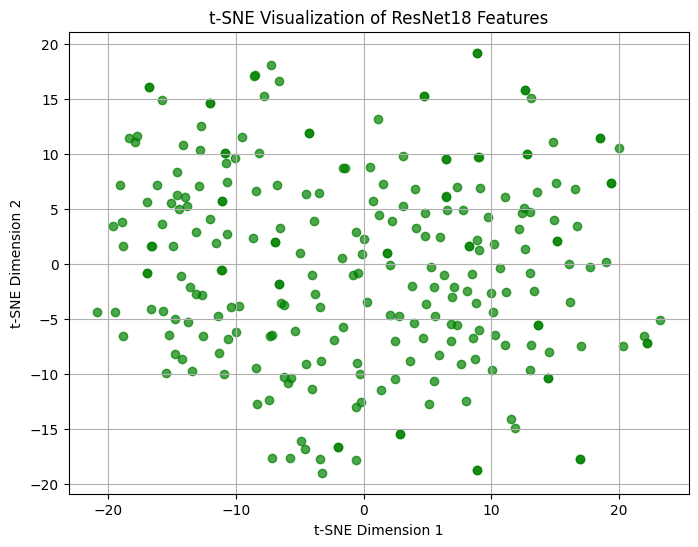

In [13]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define transform for ResNet18
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load pretrained ResNet18
resnet = models.resnet18(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove final classification layer
resnet.eval()

# Function to extract features from all images
def extract_resnet_features(images):
    features = []
    for img_array in images:
        img_pil = Image.fromarray(img_array.astype(np.uint8))
        img_tensor = transform(img_pil).unsqueeze(0)
        with torch.no_grad():
            feat = resnet(img_tensor).squeeze().numpy()
        features.append(feat)
    return np.array(features)

# --- Your image data must be in `all_images` ---
# Example (remove this if you already have real image data):
# all_images = np.random.randint(0, 255, (50, 224, 224), dtype=np.uint8)

# Step 1: Extract ResNet18 Features
resnet_features = extract_resnet_features(all_images)
print("ResNet18 Feature Shape:", resnet_features.shape)

# Step 2: Use t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(resnet_features)

# Step 3: Plot the features
plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c='green', alpha=0.7)
plt.title("t-SNE Visualization of ResNet18 Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.show()


Define and Train the Autoencoder

Epoch 1, Loss: 0.7707
Epoch 2, Loss: 0.2825
Epoch 3, Loss: 0.2397
Epoch 4, Loss: 0.2336
Epoch 5, Loss: 0.2325
Epoch 6, Loss: 0.2326
Epoch 7, Loss: 0.2323
Epoch 8, Loss: 0.2316
Epoch 9, Loss: 0.2321
Epoch 10, Loss: 0.2313
Epoch 11, Loss: 0.2301
Epoch 12, Loss: 0.2293
Epoch 13, Loss: 0.2265
Epoch 14, Loss: 0.2179
Epoch 15, Loss: 0.2038
Epoch 16, Loss: 0.1961
Epoch 17, Loss: 0.1927
Epoch 18, Loss: 0.1904
Epoch 19, Loss: 0.1879
Epoch 20, Loss: 0.1837
Epoch 21, Loss: 0.1778
Epoch 22, Loss: 0.1726
Epoch 23, Loss: 0.1685
Epoch 24, Loss: 0.1634
Epoch 25, Loss: 0.1600
Epoch 26, Loss: 0.1548
Epoch 27, Loss: 0.1520
Epoch 28, Loss: 0.1494
Epoch 29, Loss: 0.1475
Epoch 30, Loss: 0.1448
Epoch 31, Loss: 0.1425
Epoch 32, Loss: 0.1406
Epoch 33, Loss: 0.1386
Epoch 34, Loss: 0.1366
Epoch 35, Loss: 0.1344
Epoch 36, Loss: 0.1325
Epoch 37, Loss: 0.1317
Epoch 38, Loss: 0.1296
Epoch 39, Loss: 0.1279
Epoch 40, Loss: 0.1271
Epoch 41, Loss: 0.1259
Epoch 42, Loss: 0.1255
Epoch 43, Loss: 0.1228
Epoch 44, Loss: 0.12

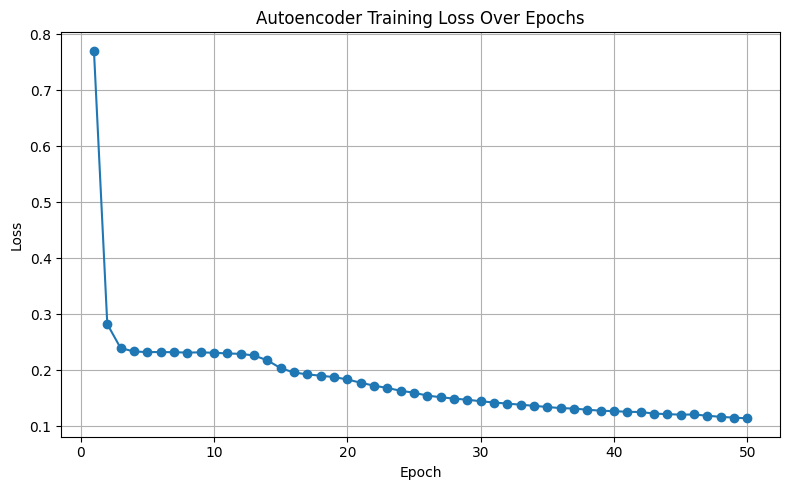

In [14]:
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt

# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(5, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Initialize model, criterion, optimizer
autoencoder = Autoencoder()
resnet_tensor = torch.tensor(resnet_features, dtype=torch.float32)
train_loader = torch.utils.data.DataLoader(resnet_tensor, batch_size=16, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop with loss recording
epochs = 50
loss_values = []

for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        encoded, decoded = autoencoder(batch)
        loss = criterion(decoded, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Plotting the loss graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_values, marker='o')
plt.title("Autoencoder Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


Extract 5D Compressed Features from Encoder

In [7]:

autoencoder.eval()


with torch.no_grad():
    compressed_features = autoencoder.encoder(resnet_tensor).numpy()

print("Compressed feature shape:", compressed_features.shape)


Compressed feature shape: (253, 5)


Build and Train the QGNN (5-qubit Quantum Neural Network)

In [8]:
!pip install pennylane


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 97.6 MB/s eta 0:00:00


In [9]:
import pennylane as qml
import torch.nn as nn


n_qubits = 5
dev = qml.device("default.qubit", wires=n_qubits)


@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    for i in range(n_qubits):
        qml.Rot(*weights[i], wires=i)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


weight_shapes = {"weights": (n_qubits, 3)}


In [10]:

qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


class QGNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.quantum = qlayer
        self.classifier = nn.Sequential(
            nn.Linear(n_qubits, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.quantum(x)
        return self.classifier(x)


In [11]:
from sklearn.model_selection import train_test_split

X = compressed_features
y = all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


Train the QGNN Model

In [12]:
import torch.optim as optim


model = QGNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0

    for i in range(len(X_train_tensor)):
        x_sample = X_train_tensor[i]
        y_sample = y_train_tensor[i].unsqueeze(0)

        optimizer.zero_grad()
        output = model(x_sample).unsqueeze(0)
        loss = criterion(output, y_sample)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = (output > 0.5).float()
        correct += (pred == y_sample).sum().item()

    acc = correct / len(X_train_tensor)
    print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Accuracy={acc*100:.2f}%")


Epoch 1: Loss=121.1985, Accuracy=68.32%
Epoch 2: Loss=104.9141, Accuracy=75.25%
Epoch 3: Loss=101.8702, Accuracy=77.72%
Epoch 4: Loss=100.6073, Accuracy=77.72%
Epoch 5: Loss=99.9053, Accuracy=77.23%
Epoch 6: Loss=99.4936, Accuracy=77.23%
Epoch 7: Loss=99.2495, Accuracy=77.23%
Epoch 8: Loss=99.1033, Accuracy=77.23%
Epoch 9: Loss=99.0139, Accuracy=77.72%
Epoch 10: Loss=98.9577, Accuracy=77.72%
Epoch 11: Loss=98.9212, Accuracy=77.72%
Epoch 12: Loss=98.8968, Accuracy=78.22%
Epoch 13: Loss=98.8855, Accuracy=78.22%
Epoch 14: Loss=98.8705, Accuracy=78.22%
Epoch 15: Loss=98.8588, Accuracy=78.22%
Epoch 16: Loss=98.8517, Accuracy=78.22%
Epoch 17: Loss=98.8463, Accuracy=78.22%
Epoch 18: Loss=98.8419, Accuracy=78.22%
Epoch 19: Loss=98.8385, Accuracy=78.22%
Epoch 20: Loss=98.8357, Accuracy=78.22%
